# Классификация: превышает ли значение IC50 медианное значение выборки

In [37]:
!pip install -q catboost
!pip install -q optuna
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Загрузка данных через диалоговое окно
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('selected_features_IC50_mM.csv')

Saving selected_features_IC50_mM.csv to selected_features_IC50_mM (1).csv


In [39]:
df.head()

,BCUT2D_MWLOW,MolWt,VSA_EState4,BCUT2D_LOGPHI,qed,PEOE_VSA7,VSA_EState8,FpDensityMorgan1,MaxAbsEStateIndex,BalabanJ,...,BCUT2D_CHGLO,BCUT2D_LOGPLOW,EState_VSA4,VSA_EState1,EState_VSA8,PEOE_VSA6,NumSaturatedHeterocycles,SMR_VSA5,fr_C_S,"IC50, mM"
0,9.700470,384.652,4.807589,2.644698,0.417362,74.032366,16.981087,0.642857,5.094096,1.164038,...,-2.343082,-2.322229,24.925325,0.00000,41.542423,54.384066,0,105.750639,0,6.239374
1,9.689226,388.684,2.153503,2.658342,0.462473,97.951860,17.670565,0.607143,3.961417,1.080362,...,-2.394690,-2.444817,23.919494,0.00000,52.176000,54.384066,0,117.834321,0,0.771831
2,9.681293,446.808,2.184127,2.679014,0.260923,74.032366,18.287216,0.562500,2.627117,1.219066,...,-2.477203,-2.565224,23.919494,2.51763,69.733111,41.542423,0,117.834321,0,223.808778
3,9.700497,398.679,4.827852,2.644709,0.377846,74.032366,17.012013,0.620690,5.097360,1.120513,...,-2.342885,-2.322030,24.925325,0.00000,41.542423,60.804888,0,112.171461,0,1.705624
4,9.700386,466.713,9.071783,2.648473,0.429038,103.003916,14.692318,0.600000,5.150510,1.136678,...,-2.342009,-2.318893,29.631406,0.00000,90.073360,65.807891,0,86.488175,0,107.131532


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BCUT2D_MWLOW              998 non-null    float64
 1   MolWt                     998 non-null    float64
 2   VSA_EState4               998 non-null    float64
 3   BCUT2D_LOGPHI             998 non-null    float64
 4   qed                       998 non-null    float64
 5   PEOE_VSA7                 998 non-null    float64
 6   VSA_EState8               998 non-null    float64
 7   FpDensityMorgan1          998 non-null    float64
 8   MaxAbsEStateIndex         998 non-null    float64
 9   BalabanJ                  998 non-null    float64
 10  EState_VSA5               998 non-null    float64
 11  MaxPartialCharge          998 non-null    float64
 12  MinEStateIndex            998 non-null    float64
 13  MolLogP                   998 non-null    float64
 14  SlogP_VSA5

In [41]:
X = df.drop(['IC50, mM'], axis=1)
y_continuous = df['IC50, mM']
print(f"Размерность данных: {X.shape}")
print(f"Признаки: {list(X.columns)}")

Размерность данных: (998, 25)
Признаки: ['BCUT2D_MWLOW', 'MolWt', 'VSA_EState4', 'BCUT2D_LOGPHI', 'qed', 'PEOE_VSA7', 'VSA_EState8', 'FpDensityMorgan1', 'MaxAbsEStateIndex', 'BalabanJ', 'EState_VSA5', 'MaxPartialCharge', 'MinEStateIndex', 'MolLogP', 'SlogP_VSA5', 'VSA_EState7', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'EState_VSA4', 'VSA_EState1', 'EState_VSA8', 'PEOE_VSA6', 'NumSaturatedHeterocycles', 'SMR_VSA5', 'fr_C_S']


In [42]:
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, y_continuous,
    test_size=0.2,
    random_state=42
)

print(f"Train: {X_train.shape[0]} образцов")
print(f"Test: {X_test.shape[0]} образцов")

Train: 798 образцов
Test: 200 образцов


In [43]:
# считаем медиану
median_ic50 = y_train_cont.median()
print(f"Медиана IC50 (на train): {median_ic50:.4f} mM")

y_train = (y_train_cont > median_ic50).astype(int)
y_test = (y_test_cont > median_ic50).astype(int)

# Распределение классов
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
print(f"\nРаспределение классов в TRAIN:")
print(f"IC50 <= медианы (0): {train_counts[0]} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"IC50 > медианы (1): {train_counts[1]} ({train_counts[1]/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в TEST:")
print(f"IC50 <= медианы (0): {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"IC50 > медианы (1): {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")

Медиана IC50 (на train): 48.3150 mM

Распределение классов в TRAIN:
IC50 <= медианы (0): 399 (50.0%)
IC50 > медианы (1): 399 (50.0%)

Распределение классов в TEST:
IC50 <= медианы (0): 105 (52.5%)
IC50 > медианы (1): 95 (47.5%)


In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение моделей

In [45]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

results = {}
for name, model in models.items():
    print(f"\n--- Обучение {name} ---")

    # Выбираем данные (масштабированные для линейных моделей и SVM)
    if name in ['Logistic Regression', 'SVM']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Обучение модели
    model.fit(X_train_use, y_train)

    # Предсказания
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]

    # Кросс-валидация на train
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='roc_auc')

    # Метрики на test
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Сохранение результатов
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



--- Обучение Logistic Regression ---
Accuracy: 0.5950
F1-score: 0.5846
ROC AUC: 0.6744
CV ROC AUC: 0.7053 ± 0.0263

--- Обучение Random Forest ---
Accuracy: 0.7000
F1-score: 0.6809
ROC AUC: 0.7848
CV ROC AUC: 0.7697 ± 0.0275

--- Обучение Extra Trees ---
Accuracy: 0.7000
F1-score: 0.6703
ROC AUC: 0.7877
CV ROC AUC: 0.7548 ± 0.0237

--- Обучение Gradient Boosting ---
Accuracy: 0.7000
F1-score: 0.6842
ROC AUC: 0.7526
CV ROC AUC: 0.7575 ± 0.0339

--- Обучение XGBoost ---
Accuracy: 0.7250
F1-score: 0.7120
ROC AUC: 0.7700
CV ROC AUC: 0.7566 ± 0.0164

--- Обучение SVM ---
Accuracy: 0.6500
F1-score: 0.6465
ROC AUC: 0.7396
CV ROC AUC: 0.7487 ± 0.0229

--- Обучение Naive Bayes ---
Accuracy: 0.5600
F1-score: 0.6207
ROC AUC: 0.6333
CV ROC AUC: 0.6490 ± 0.0271


Сравнение моделей

In [51]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()],
    'CV ROC AUC': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
})
best_idx = results_df['ROC AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = results[best_model_name]

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   ROC AUC: {best_model['roc_auc']:.4f}")
print(f"   Accuracy: {best_model['accuracy']:.4f}")
print(f"   F1-Score: {best_model['f1_score']:.4f}")


ЛУЧШАЯ МОДЕЛЬ: Extra Trees
   ROC AUC: 0.7877
   Accuracy: 0.7000
   F1-Score: 0.6703


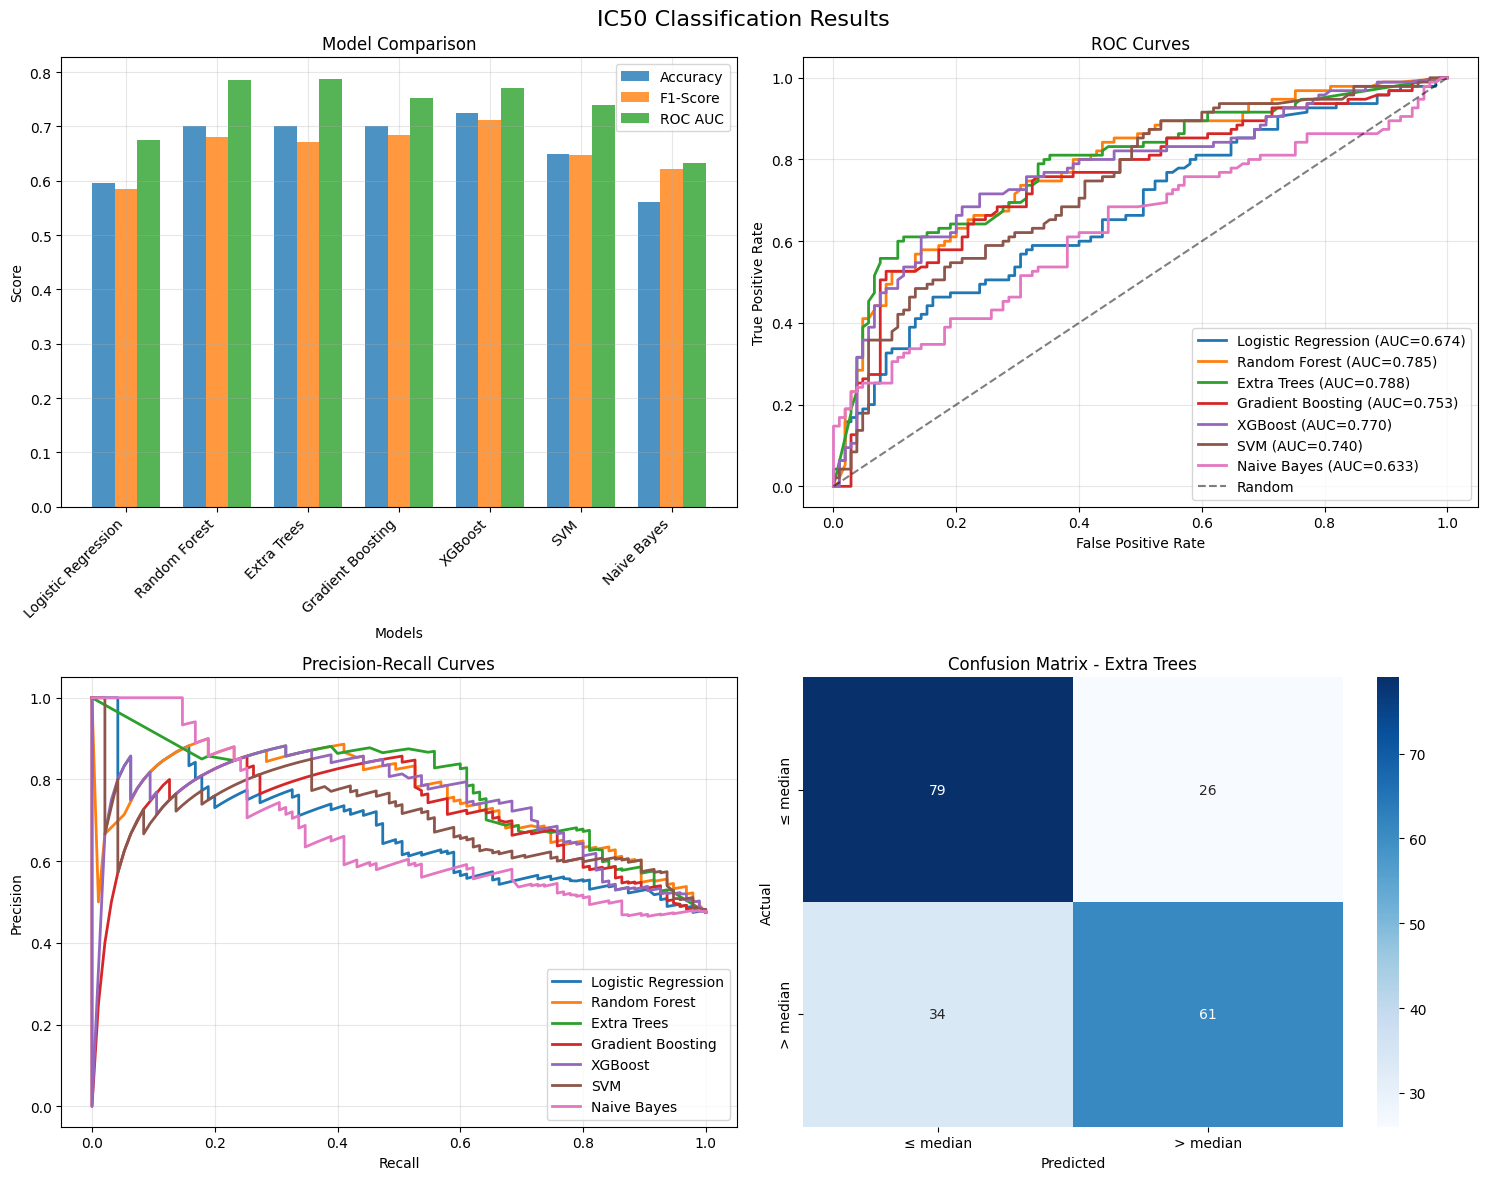

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('IC50 Classification Results', fontsize=16)

# 1. Сравнение моделей
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.25

ax1.bar(x_pos - width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax1.bar(x_pos, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax1.bar(x_pos + width, results_df['ROC AUC'], width, label='ROC AUC', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC кривые
ax2 = axes[0, 1]
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    auc_score = results[name]['roc_auc']
    ax2.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})", linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall кривые
ax3 = axes[1, 0]
for name in results.keys():
    precision, recall, _ = precision_recall_curve(y_test, results[name]['y_pred_proba'])
    ax3.plot(recall, precision, label=name, linewidth=2)

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix лучшей модели
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, best_model['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['≤ median', '> median'],
            yticklabels=['≤ median', '> median'])
ax4.set_title(f'Confusion Matrix - {best_model_name}')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()

МОДЕЛЬ: Extra Trees

79 - True Negatives (правильно предсказан класс "≤ median")
26 - False Positives (ошибочно предсказан как "> median")
34 - False Negatives (ошибочно предсказан как "≤ median")
61 - True Positives (правильно предсказан класс "> median")

Accuracy = (79 + 61) / (79 + 26 + 34 + 61) = 140/200 = 70%
Класс "≤ median": 79/(79+26) = 75.2% - хорошо
Класс "> median": 61/(34+61) = 64.2% - средне

Полнота (Recall):
Класс "≤ median": 79/(79+34) = 69.9%
Класс "> median": 61/(26+61) = 70.1%

Модель неплохо разделила классы (70% точность), правильных предсказаний больше, чем ошибок.
Но модель допустила 26 ложных срабатываний - соединения с IC50 ≤ медианы модель считает активными, и 34 пропуска - активные соединения (> медианы) модель считает неактивными.

Т.е. мы ложно отбираем 26 соединений  и упускаем 34 потенциально активных


In [53]:
comparison_data = []
true_0, true_1 = sum(y_test == 0), sum(y_test == 1)

for name in results.keys():
    y_pred = results[name]['y_pred']
    pred_0, pred_1 = sum(y_pred == 0), sum(y_pred == 1)
    correct = sum(y_test == y_pred)

    comparison_data.append({
        'Model': name,
        'True_Class_0 (≤ медианы)': true_0,
        'True_Class_1 (> медианы)': true_1,
        'Pred_Class_0 (≤ медианы)': pred_0,
        'Pred_Class_1 (> медианы)': pred_1,
        'Correct': correct,
        'Total': len(y_test),
        'Accuracy': correct/len(y_test)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nСводная таблица предсказаний:")
print(comparison_df.to_string(index=False))


Сводная таблица предсказаний:
              Model  True_Class_0 (≤ медианы)  True_Class_1 (> медианы)  Pred_Class_0 (≤ медианы)  Pred_Class_1 (> медианы)  Correct  Total  Accuracy
Logistic Regression                       105                        95                       100                       100      119    200     0.595
      Random Forest                       105                        95                       107                        93      140    200     0.700
        Extra Trees                       105                        95                       113                        87      140    200     0.700
  Gradient Boosting                       105                        95                       105                        95      140    200     0.700
            XGBoost                       105                        95                       104                        96      145    200     0.725
                SVM                       105                        